## Notebook for generating multicomponent dataset (for Chemprop)

### Frequence splitting-I (Making sure molecules are not repeated in test set)

**Created on 5th April, 2022; re-modified on 31st August; re-re-modified on 23rd January, 2024**

In [1]:
import warnings
warnings.filterwarnings('ignore')
import requests
#from selenium import webdriver
import os
import json
import csv
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as m
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
# from ifg import identify_functional_groups ## Need ifg.py file
import rdkit.Chem.rdMolDescriptors as MolDescriptors
import rdkit.Chem.Descriptors as Descriptors
import rdkit.Chem.Lipinski as Lipinski
from rdkit.Chem import Descriptors3D
from rdkit.Chem import AllChem, DataStructs, Fragments
from mordred import Calculator, descriptors, CPSA
from mordred.GeometricalIndex import Radius3D, Diameter3D, GeometricalShapeIndex

In [2]:
%%bash
pwd
ls -ltr

/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/Science-rev-1/ionic-conductivity_2.1/dataset_v2.0/common-log-output/cluster-split-1/gen-split-again
total 4440
-rw-------@ 1 riteshk  staff  626696 Jan 23 23:44 all_multi_comp_add.csv
-rw-------@ 1 riteshk  staff  703675 Jan 23 23:44 all_multi_comp_comb.csv
-rw-------@ 1 riteshk  staff  206225 Jan 24 00:52 split_dataset_clus1.ipynb
-rw-------@ 1 riteshk  staff  728011 Jan 24 00:53 all_multi_comp.csv


In [3]:
df = pd.read_csv('all_multi_comp.csv')
df

,solv_1_sm,solv_2_sm,solv_3_sm,solv_4_sm,salt_sm,conductivity_log
0,O=C1OCCO1,COC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,2.459589
1,O=C1OCCO1,CCCCOC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.774952
2,O=C1OCCO1,CC(C)COC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.686399
3,O=C1OCCO1,CCC(C)OC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.871802
4,CCOC(=O)OCC,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.741937
...,...,...,...,...,...,...
10191,CS(=O)C,COCCOC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.547563
10192,CS(=O)C,COCCOC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,2.624669
10193,CS(=O)C,COCCOC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,2.772589
10194,CS(=O)C,COCCOC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,2.687847


In [4]:
df_comb = pd.read_csv('all_multi_comp_comb.csv')
df_add = pd.read_csv('all_multi_comp_add.csv')
df['conductivity_log'] = np.log10(np.exp(df['conductivity_log']))
df_comb['conductivity_log'] = np.log10(np.exp(df_comb['conductivity_log']))
df

,solv_1_sm,solv_2_sm,solv_3_sm,solv_4_sm,salt_sm,conductivity_log
0,O=C1OCCO1,COC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.068186
1,O=C1OCCO1,CCCCOC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,0.770852
2,O=C1OCCO1,CC(C)COC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,0.732394
3,O=C1OCCO1,CCC(C)OC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,0.812913
4,CCOC(=O)OCC,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.322219
...,...,...,...,...,...,...
10191,CS(=O)C,COCCOC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,0.672098
10192,CS(=O)C,COCCOC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.139879
10193,CS(=O)C,COCCOC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.204120
10194,CS(=O)C,COCCOC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.167317


just for testing (ignore)

In [18]:
def get_tot_num_bonds(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    return mol.GetNumBonds()

In [23]:
tt = df_comb.copy()
tt['num_bonds_solv'] = tt['solv_comb_sm'].apply(get_tot_num_bonds)
tt['num_bonds_salt'] = tt['salt_sm'].apply(get_tot_num_bonds)
tt

,solv_comb_sm,salt_sm,conductivity_log,num_bonds_solv,num_bonds_salt
0,O=C1OCCO1.COC(=O)OC,[Li+].F[P-](F)(F)(F)(F)F,1.068186,21,6
1,O=C1OCCO1.CCCCOC(=O)OC,[Li+].F[P-](F)(F)(F)(F)F,0.770852,30,6
2,O=C1OCCO1.CC(C)COC(=O)OC,[Li+].F[P-](F)(F)(F)(F)F,0.732394,30,6
3,O=C1OCCO1.CCC(C)OC(=O)OC,[Li+].F[P-](F)(F)(F)(F)F,0.812913,30,6
4,CCOC(=O)OCC,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.322219,17,14
...,...,...,...,...,...
10191,CS(=O)C.COCCOC,[Li+].F[P-](F)(F)(F)(F)F,0.672098,24,6
10192,CS(=O)C.COCCOC,[Li+].F[P-](F)(F)(F)(F)F,1.139879,24,6
10193,CS(=O)C.COCCOC,[Li+].F[P-](F)(F)(F)(F)F,1.204120,24,6
10194,CS(=O)C.COCCOC,[Li+].F[P-](F)(F)(F)(F)F,1.167317,24,6


In [22]:
print(tt['num_bonds_solv'].min())
print(tt['num_bonds_solv'].max())
print(tt['num_bonds_solv'].mean())

5
86
25.967045900353078


In [24]:
print(tt['num_bonds_salt'].min())
print(tt['num_bonds_salt'].max())
print(tt['num_bonds_salt'].mean())

0
100
14.678010984699883


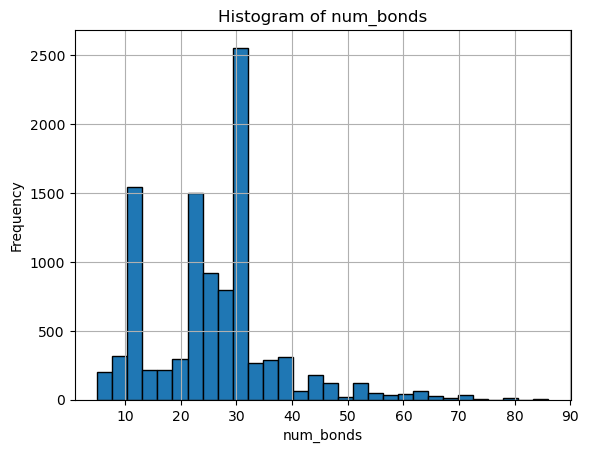

In [25]:
# Plot histogram of 'num_bonds' column
tt['num_bonds_solv'].hist(bins=30, edgecolor='black')

plt.title('Histogram of num_bonds_solv')
plt.xlabel('num_bonds')
plt.ylabel('Frequency')

plt.show()

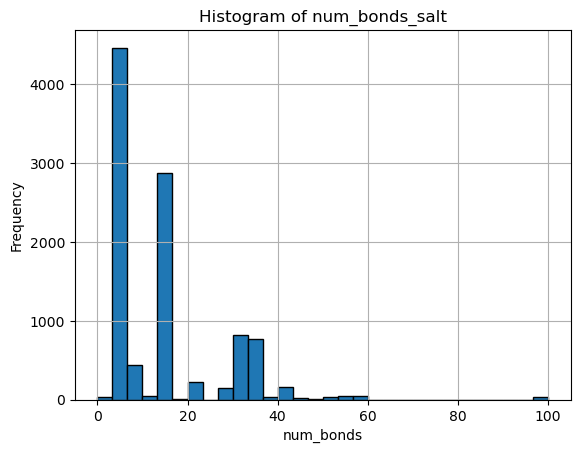

In [26]:
# Plot histogram of 'num_bonds' column
tt['num_bonds_salt'].hist(bins=30, edgecolor='black')

plt.title('Histogram of num_bonds_salt')
plt.xlabel('num_bonds')
plt.ylabel('Frequency')

plt.show()

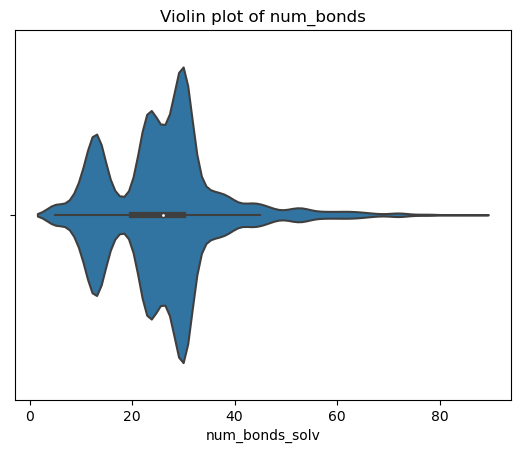

In [28]:
import seaborn as sns

sns.violinplot(x=tt['num_bonds_solv'])

plt.title('Violin plot of num_bonds')

plt.show()

till here...

In [5]:
df['solv_1_sm'] = df['solv_1_sm'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))
df['solv_2_sm'] = df['solv_2_sm'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)) if pd.notna(x) else x)
df['solv_3_sm'] = df['solv_3_sm'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)) if pd.notna(x) else x)
df['solv_4_sm'] = df['solv_4_sm'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)) if pd.notna(x) else x)
df

,solv_1_sm,solv_2_sm,solv_3_sm,solv_4_sm,salt_sm,conductivity_log
0,O=C1OCCO1,COC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.068186
1,O=C1OCCO1,CCCCOC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,0.770852
2,O=C1OCCO1,COC(=O)OCC(C)C,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,0.732394
3,O=C1OCCO1,CCC(C)OC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,0.812913
4,CCOC(=O)OCC,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.322219
...,...,...,...,...,...,...
10191,CS(C)=O,COCCOC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,0.672098
10192,CS(C)=O,COCCOC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.139879
10193,CS(C)=O,COCCOC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.204120
10194,CS(C)=O,COCCOC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.167317


In [6]:
## function for creating dictionary of electrolyte solvent SMILES, with keys as the SMILES and values as the frequency of the SMILES
cols = df.columns
def frequency_count(df):
    df_ = df.copy()
    df_.reset_index(inplace=True, drop=True)
    freq_dct = {}
    for i in range(len(df_)):
        for j in range(4):
            if df_[cols[j]][i] != np.nan:
                freq_dct[df_[cols[j]][i]] = freq_dct.get(df_[cols[j]][i],0)+1 ## add 1 to the value of the key if the key already exists, otherwise add the key to the dictionary
            else:
                pass
    del freq_dct[np.nan]
    return freq_dct

In [7]:
dict_solv = frequency_count(df)
dict_solv

{'O=C1OCCO1': 2877,
 'COC(=O)OC': 581,
 'CCCCOC(=O)OC': 1,
 'COC(=O)OCC(C)C': 1,
 'CCC(C)OC(=O)OC': 1,
 'CCOC(=O)OCC': 2487,
 'CCOC(=O)OC(C)F': 14,
 'CC(F)OC(=O)OCC(F)(F)F': 11,
 'O=C1OCC(F)O1': 66,
 'O=C1OC(F)C(F)O1': 23,
 'CCOC(=O)OC': 704,
 'FC(F)C(F)(F)COC(F)(F)C(F)F': 67,
 'O=C1OCC(CC(F)(C(F)(F)F)C(F)(F)F)O1': 15,
 'COC(=O)OCC(F)(F)F': 10,
 'COC(F)(C(F)(F)C(F)(F)F)C(F)(C(F)(F)F)C(F)(F)F': 5,
 'CC(OC(F)(F)C(F)C(F)(F)F)C(F)(F)C(F)C(F)(F)F': 15,
 'CC1COC(=O)O1': 5885,
 'CCOCCOCC': 55,
 'ClCCl': 109,
 'C1CCOC1': 292,
 'Cc1ccccc1': 83,
 'CC1CCCO1': 270,
 'COCCOC': 729,
 'C1COCO1': 153,
 'O=c1occo1': 10,
 'C=CCCCOCC1COC(=O)O1': 5,
 'CO[Si](CCCOCC1COC(=O)O1)(OC)OC': 5,
 'CCO[Si](CCCOCC1COC(=O)O1)(OCC)OCC': 5,
 'C[Si](C)(C)O[Si](C)(C)CCCOCC1COC(=O)O1': 5,
 'CCCC(=O)OC': 6,
 'CN1CCCC1=O': 1,
 'CCCCOCCOCCCC': 19,
 'COP(=O)(OC)OC': 5,
 'O=C1CCCO1': 474,
 'COC(=O)OCCCF': 5,
 'CCCOC(=O)OC': 21,
 'COC(=O)OCCC(F)(F)F': 5,
 'COC(=O)OCC(F)(F)C(F)F': 5,
 'COC(=O)OCC(F)(F)C(F)(F)F': 5,
 'O=C1OCC(CF)

**Frequency cutoff for test set: 15**

In [8]:
print(len(dict_solv))

low_freq_set = set()
mid_freq_set = set()
high_freq_set = set()

for key in dict_solv:
    if dict_solv[key] >= 100:
        high_freq_set.add(key)

for key in dict_solv:
    if 15 < dict_solv[key] <= 100:
        mid_freq_set.add(key)

for key in dict_solv:
    if dict_solv[key] <= 15:
        low_freq_set.add(key)

print("Length of high frequency solvents:", len(high_freq_set))
print("Length of mid frequency solvents:", len(mid_freq_set))
print("Length of low frequency solvents:", len(low_freq_set))

202
Length of high frequency solvents: 20
Length of mid frequency solvents: 34
Length of low frequency solvents: 148


In [9]:
## find all entries with low frequency solvents
low_freq_ind = set()
for i in range(len(df)):
    for j in range(4):
        if df[cols[j]][i] in low_freq_set:
            low_freq_ind.add(i)
low_freq_ind = list(low_freq_ind)
len(low_freq_ind)

906

In [10]:
low_freq_df = df.iloc[low_freq_ind,:]
low_freq_df.reset_index(inplace=True, drop=True)
low_freq_df

,solv_1_sm,solv_2_sm,solv_3_sm,solv_4_sm,salt_sm,conductivity_log
0,O=C1OCCO1,CCCCOC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,0.770852
1,O=C1OCCO1,COC(=O)OCC(C)C,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,0.732394
2,O=C1OCCO1,CCC(C)OC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,0.812913
3,CCOC(=O)OC(C)F,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.000000
4,CCOC(=O)OC(C)F,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.113943
...,...,...,...,...,...,...
901,COCCOCCOCCOCC1COB(c2ccc(B3OCC(COCCOCCOCCOC)O3)...,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-2.161151
902,COCCOCCOCCOCC1COB(c2ccc(B3OCC(COCCOCCOCCOC)O3)...,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-1.920819
903,COCCOCCOCCOCC1COB(c2ccc(B3OCC(COCCOCCOCCOC)O3)...,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-1.161151
904,COCCOCCOCCOCC1COB(c2ccc(B3OCC(COCCOCCOCCOC)O3)...,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-0.638272


In [11]:
## finding rest of the entries that are not in the low frequency solvents
rest_ind = [i for i in range(len(df)) if i not in low_freq_ind]
rest_df = df.iloc[rest_ind,:]
rest_df.reset_index(drop=True, inplace=True)
rest_df

,solv_1_sm,solv_2_sm,solv_3_sm,solv_4_sm,salt_sm,conductivity_log
0,O=C1OCCO1,COC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.068186
1,CCOC(=O)OCC,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.322219
2,CCOC(=O)OCC,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.414973
3,CCOC(=O)OCC,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.477121
4,CCOC(=O)OCC,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.518514
...,...,...,...,...,...,...
9285,CS(C)=O,COCCOC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,0.672098
9286,CS(C)=O,COCCOC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.139879
9287,CS(C)=O,COCCOC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.204120
9288,CS(C)=O,COCCOC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.167317


In [12]:
rest_df_comb = df_comb.iloc[rest_ind,:]
rest_df_add = df_add.iloc[rest_ind,:]
rest_df_comb.reset_index(drop=True, inplace=True)
rest_df_add.reset_index(drop=True, inplace=True)
rest_df_comb

,solv_comb_sm,salt_sm,conductivity_log
0,O=C1OCCO1.COC(=O)OC,[Li+].F[P-](F)(F)(F)(F)F,1.068186
1,CCOC(=O)OCC,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.322219
2,CCOC(=O)OCC,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.414973
3,CCOC(=O)OCC,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.477121
4,CCOC(=O)OCC,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.518514
...,...,...,...
9285,CS(=O)C.COCCOC,[Li+].F[P-](F)(F)(F)(F)F,0.672098
9286,CS(=O)C.COCCOC,[Li+].F[P-](F)(F)(F)(F)F,1.139879
9287,CS(=O)C.COCCOC,[Li+].F[P-](F)(F)(F)(F)F,1.204120
9288,CS(=O)C.COCCOC,[Li+].F[P-](F)(F)(F)(F)F,1.167317


In [13]:
rest_dict = frequency_count(rest_df)
rest_solv = list(rest_dict.keys())

In [14]:
## excluding the entries in low_freq_df that are also in rest_df -> solvent SMILES should not repeat between test & train/validation
rem_ind = set()
for i in range(len(low_freq_df)):
    for j in range(4):
        if low_freq_df[cols[j]][i] in rest_solv:
            rem_ind.add(i)
print(len(rem_ind))

348


In [15]:
rem_ind = list(rem_ind)
test_df = low_freq_df.copy()
test_df.drop(index=rem_ind, inplace=True)
test_df.reset_index(drop=True, inplace=True)
test_df

,solv_1_sm,solv_2_sm,solv_3_sm,solv_4_sm,salt_sm,conductivity_log
0,CCOC(=O)OC(C)F,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.000000
1,CCOC(=O)OC(C)F,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.113943
2,CCOC(=O)OC(C)F,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.204120
3,CCOC(=O)OC(C)F,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.278754
4,CCOC(=O)OC(C)F,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.414973
...,...,...,...,...,...,...
553,COCCOCCOCCOCC1COB(c2ccc(B3OCC(COCCOCCOCCOC)O3)...,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-2.161151
554,COCCOCCOCCOCC1COB(c2ccc(B3OCC(COCCOCCOCCOC)O3)...,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-1.920819
555,COCCOCCOCCOCC1COB(c2ccc(B3OCC(COCCOCCOCCOC)O3)...,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-1.161151
556,COCCOCCOCCOCC1COB(c2ccc(B3OCC(COCCOCCOCCOC)O3)...,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-0.638272


In [16]:
low_freq_df_comb = df_comb.iloc[low_freq_ind,:]
low_freq_df_add = df_add.iloc[low_freq_ind,:]
test_df_comb = low_freq_df_comb.copy(); test_df_comb.reset_index(drop=True, inplace=True)
test_df_add = low_freq_df_add.copy(); test_df_add.reset_index(drop=True, inplace=True)
test_df_comb.drop(index=rem_ind, inplace=True)
test_df_comb.reset_index(drop=True, inplace=True)
test_df_add.drop(index=rem_ind, inplace=True)
test_df_add.reset_index(drop=True, inplace=True)
print(len(test_df_comb))
test_df_add

558


,solv_ratio_1,solv_ratio_2,solv_ratio_3,solv_ratio_4,mol_wt_solv_1,mol_wt_solv_2,mol_wt_solv_3,mol_wt_solv_4,mol_wt_salt,conc_salt,temperature
0,1.0,0.0,0.0,0.0,136.053572,0.0,0.0,0.0,286.933298,1.00,10.0
1,1.0,0.0,0.0,0.0,136.053572,0.0,0.0,0.0,286.933298,1.00,20.0
2,1.0,0.0,0.0,0.0,136.053572,0.0,0.0,0.0,286.933298,1.00,30.0
3,1.0,0.0,0.0,0.0,136.053572,0.0,0.0,0.0,286.933298,1.00,40.0
4,1.0,0.0,0.0,0.0,136.053572,0.0,0.0,0.0,286.933298,1.00,60.0
...,...,...,...,...,...,...,...,...,...,...,...
553,1.0,0.0,0.0,0.0,570.301888,0.0,0.0,0.0,286.933298,0.88,25.0
554,1.0,0.0,0.0,0.0,570.301888,0.0,0.0,0.0,286.933298,0.88,30.0
555,1.0,0.0,0.0,0.0,570.301888,0.0,0.0,0.0,286.933298,0.88,50.0
556,1.0,0.0,0.0,0.0,570.301888,0.0,0.0,0.0,286.933298,0.88,70.0


In [17]:
test_df_add.loc[test_df_add['solv_ratio_2'] != 0.0] ## the only binary solvent electrolytes

,solv_ratio_1,solv_ratio_2,solv_ratio_3,solv_ratio_4,mol_wt_solv_1,mol_wt_solv_2,mol_wt_solv_3,mol_wt_solv_4,mol_wt_salt,conc_salt,temperature
437,0.567146,0.432854,0.0,0.0,182.070796,182.016634,0.0,0.0,186.939685,2.0,25.0
438,0.395816,0.604184,0.0,0.0,182.070796,182.016634,0.0,0.0,186.939685,1.5,25.0
439,0.303979,0.696021,0.0,0.0,182.070796,182.016634,0.0,0.0,186.939685,1.2,25.0


In [18]:
test_solv = frequency_count(test_df)
test_solv = list(test_solv.keys())
test_solv

['CCOC(=O)OC(C)F',
 'CC(F)OC(=O)OCC(F)(F)F',
 'CCOCCOCCF',
 'CCOCCOCC(F)F',
 'CCOCCOCC(F)(F)F',
 'COCCCCOC',
 'COCC(F)(F)C(F)(F)COC',
 'COCCO[Si](C)(C)C',
 'COCCOCCO[Si](C)(C)C',
 'COCCOCCOCCO[Si](C)(C)C',
 'COCCOCCOCCOCCO[Si](C)(C)C',
 'COCCOCCOCCOCCOCCO[Si](C)(C)C',
 'COCCOCCOCCOCCOCCOCCOCCO[Si](C)(C)C',
 'C[Si](C)(C)OCCOCCOCCO[Si](C)(C)C',
 'C[Si](C)(C)OCCOCCOCCOCCO[Si](C)(C)C',
 'COC(=O)C(F)F',
 'COCCOCCOCCO[Si](C)(C)CCCOCC1COC(=O)O1',
 'C[N+](=O)[O-]',
 'CC(=O)OCCF',
 'C=CCCCOCC1COC(=O)O1',
 'CO[Si](CCCOCC1COC(=O)O1)(OC)OC',
 'CCO[Si](CCCOCC1COC(=O)O1)(OCC)OCC',
 'C[Si](C)(C)O[Si](C)(C)CCCOCC1COC(=O)O1',
 'CCOC(=O)CF',
 'COCCOCCOCCC[Si](C)(F)F',
 'COCCOCCOCCC[Si](C)(C)F',
 'COCCOCCOCCC[Si](C)(C)C',
 'COCCO[Si](C)(C)CCCC#N',
 'O=C(OCF)OCF',
 'COCCOCCO[Si](C)(C)CCCC#N',
 'COCCOCCOCCO[Si](C)(C)CCCC#N',
 'COCCO[Si](C)(CCC#N)OCCOC',
 'COCCO[Si](CCC#N)(OCCOC)OCCOC',
 'CCOCCOC',
 'COC(=O)OCCCF',
 'COC(=O)OCCC(F)(F)F',
 'COC(=O)OCC(F)(F)C(F)F',
 'COC(=O)OCC(F)(F)C(F)(F)F',
 'COCCOCCF',
 '

In [19]:
ref_mol = [Chem.MolFromSmiles(sm) for sm in test_solv]
ref_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in ref_mol]

In [20]:
def check_similarity(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol_fps = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    similarity = [DataStructs.FingerprintSimilarity(mol_fps, ref) for ref in ref_fps]
    max_sim = max(similarity)
    ind = similarity.index(max_sim)
    return max_sim, ind

In [21]:
for i in range(len(rest_solv)):
    max_sim, ind = check_similarity(rest_solv[i])
    sm_max_sim = test_solv[ind]
    if max_sim == 1.0:
        print(rest_solv[i], max_sim, sm_max_sim)

COCCOCCOC 1.0 COCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOC
COCCOCCOCCOC 1.0 COCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOC
COCCOCCOCCOCCOC 1.0 COCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOC


In [22]:
## assigning entries in rest_df having mid frequency solvents to the validation set
val_ind = set()
for i in range(len(rest_df)):
    for j in range(4):
        if rest_df[cols[j]][i] in mid_freq_set:
            val_ind.add(i)
len(val_ind)

1063

In [23]:
val_ind = list(val_ind)
val_df = rest_df.iloc[val_ind,:]
val_df.reset_index(drop=True, inplace=True)
val_df

,solv_1_sm,solv_2_sm,solv_3_sm,solv_4_sm,salt_sm,conductivity_log
0,O=S1(=O)CCCC1,FC(F)C(F)(F)COC(F)(F)C(F)F,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-0.136677
1,O=S1(=O)CCCC1,FC(F)C(F)(F)COC(F)(F)C(F)F,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-0.045757
2,CCS(=O)(=O)CC1CCCCC1,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.178977
3,O=S1(=O)CCCC1,FC(F)C(F)(F)COC(F)(F)C(F)F,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-0.045757
4,C1CCOC1,CCOCC,NaN,NaN,[Li+].[B-](F)(F)(F)F,0.118466
...,...,...,...,...,...,...
1058,COCCOCC(F)(F)F,NaN,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,0.527243
1059,COCCOCC(F)(F)F,NaN,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,0.503109
1060,COCCOCC(F)(F)F,NaN,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,0.472171
1061,COCCOCC(F)(F)F,NaN,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,0.438701


In [24]:
val_df_comb = rest_df_comb.iloc[val_ind,:]
val_df_add = rest_df_add.iloc[val_ind,:]
val_df_comb.reset_index(drop=True, inplace=True)
val_df_add.reset_index(drop=True, inplace=True)
val_df_comb

,solv_comb_sm,salt_sm,conductivity_log
0,O=S1(=O)CCCC1.C(C(C(F)F)(F)F)OC(C(F)F)(F)F,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-0.136677
1,O=S1(=O)CCCC1.C(C(C(F)F)(F)F)OC(C(F)F)(F)F,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-0.045757
2,CCS(=O)(=O)CC1CCCCC1,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.178977
3,O=S1(=O)CCCC1.C(C(C(F)F)(F)F)OC(C(F)F)(F)F,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-0.045757
4,C1CCOC1.CCOCC,[Li+].[B-](F)(F)(F)F,0.118466
...,...,...,...
1058,COCCOCC(F)(F)F,[Li+].F[P-](F)(F)(F)(F)F,0.527243
1059,COCCOCC(F)(F)F,[Li+].F[P-](F)(F)(F)(F)F,0.503109
1060,COCCOCC(F)(F)F,[Li+].F[P-](F)(F)(F)(F)F,0.472171
1061,COCCOCC(F)(F)F,[Li+].F[P-](F)(F)(F)(F)F,0.438701


In [25]:
val_solv_freq = frequency_count(val_df)
val_solv = list(val_solv_freq.keys())
val_solv_freq

{'O=S1(=O)CCCC1': 73,
 'FC(F)C(F)(F)COC(F)(F)C(F)F': 42,
 'CCS(=O)(=O)CC1CCCCC1': 31,
 'C1CCOC1': 25,
 'CCOCC': 16,
 'O=C1OCC(F)O1': 55,
 'O=C1OC(F)C(F)O1': 23,
 'C[Si](C)(C)OCCC#N': 25,
 'CCOC(=O)OC': 170,
 'O=C1OCCO1': 252,
 'N#Cc1ccccn1': 54,
 'COCCOCCOCCOCCOC': 9,
 'CS(C)=O': 73,
 'CCOCCOCC': 55,
 'COCCOCCOC': 75,
 'N#CCCCCC#N': 66,
 'N#CCCCC#N': 31,
 'CCCC#N': 40,
 'COC(=O)OC': 26,
 'CC1COC(=O)O1': 73,
 'Cc1ccccc1': 83,
 'CCCCOCCOCCCC': 19,
 'CCOC(=O)OCC': 5,
 'COC(=O)OCF': 55,
 'C1COCO1': 42,
 'N#CCCC#N': 2,
 'CC#N': 3,
 'CCCC[N+]1(C)CCCC1.O=S(=O)([N-]S(=O)(=O)C(F)(F)F)C(F)(F)F': 20,
 'CCS(C)(=O)=O': 33,
 'CCCOC(=O)OC': 21,
 'COC(=O)OCCF': 19,
 'C[Si](C)(C)O[Si](C)(CCC1COC(=O)O1)O[Si](C)(C)C': 40,
 'C[Si](C)(C)O[Si](C)(C)CCC1COC(=O)O1': 20,
 'CC1CCS(=O)(=O)C1': 28,
 'COCCOC': 112,
 'COCCOCCOCCOC': 19,
 'O=C1CCCO1': 18,
 'CCOC(C)=O': 10,
 'O=C1OCCC1F': 5,
 'N#CCCOB(OCCC#N)OCCC#N': 5,
 'COC(F)(F)C(F)(F)C(F)(F)C(F)(F)F': 29,
 'CC1CCCO1': 5,
 'FC(F)(F)C(F)(F)COC(F)(F)C(F)(F)F': 20,
 

In [26]:
for i in range(len(val_solv)):
    max_sim, ind = check_similarity(val_solv[i])
    sm_max_sim = test_solv[ind]
    if max_sim == 1.0:
        print(val_solv[i], max_sim, sm_max_sim)

COCCOCCOCCOCCOC 1.0 COCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOC
COCCOCCOC 1.0 COCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOC
COCCOCCOCCOC 1.0 COCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOC


In [27]:
train_ind = [i for i in range(len(rest_df)) if i not in val_ind] ## assigning entries in rest_df not present in val_df to the training set
len(train_ind)

8227

In [28]:
train_df = rest_df.iloc[train_ind,:]
train_df.reset_index(drop=True, inplace=True)
train_df

,solv_1_sm,solv_2_sm,solv_3_sm,solv_4_sm,salt_sm,conductivity_log
0,O=C1OCCO1,COC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.068186
1,CCOC(=O)OCC,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.322219
2,CCOC(=O)OCC,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.414973
3,CCOC(=O)OCC,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.477121
4,CCOC(=O)OCC,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.518514
...,...,...,...,...,...,...
8222,O=S1(=O)CCCC1,CCOC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,0.786041
8223,O=S1(=O)CCCC1,CCOC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,0.749118
8224,O=S1(=O)CCCC1,CCOC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,0.796227
8225,O=S1(=O)CCCC1,CCOC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,0.743823


In [29]:
train_df_comb = rest_df_comb.iloc[train_ind,:]
train_df_add = rest_df_add.iloc[train_ind,:]
# train_df_comb.reset_index(drop=True, inplace=True)
# train_df_add.reset_index(drop=True, inplace=True)
# print(train_df_comb.head())
train_df_add

,solv_ratio_1,solv_ratio_2,solv_ratio_3,solv_ratio_4,mol_wt_solv_1,mol_wt_solv_2,mol_wt_solv_3,mol_wt_solv_4,mol_wt_salt,conc_salt,temperature
0,0.447059,0.552941,0.0,0.0,88.016044,90.031694,0.0,0.0,151.980186,1.0,25.0
1,1.000000,0.000000,0.0,0.0,118.062994,0.000000,0.0,0.0,286.933298,1.0,10.0
2,1.000000,0.000000,0.0,0.0,118.062994,0.000000,0.0,0.0,286.933298,1.0,20.0
3,1.000000,0.000000,0.0,0.0,118.062994,0.000000,0.0,0.0,286.933298,1.0,30.0
4,1.000000,0.000000,0.0,0.0,118.062994,0.000000,0.0,0.0,286.933298,1.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...
9219,0.300000,0.700000,0.0,0.0,120.024501,104.047344,0.0,0.0,151.980186,1.0,33.0
9220,1.000000,0.000000,0.0,0.0,120.024501,0.000000,0.0,0.0,151.980186,1.0,25.0
9221,1.000000,0.000000,0.0,0.0,120.024501,0.000000,0.0,0.0,151.980186,1.0,33.0
9222,1.000000,0.000000,0.0,0.0,120.024501,0.000000,0.0,0.0,151.980186,1.0,25.0


In [30]:
train_solv_freq = frequency_count(train_df)
train_solv = list(train_solv_freq.keys())
train_solv_freq

{'O=C1OCCO1': 2510,
 'COC(=O)OC': 538,
 'CCOC(=O)OCC': 2455,
 'CCOC(=O)OC': 517,
 'CC1COC(=O)O1': 5794,
 'ClCCl': 109,
 'C1CCOC1': 261,
 'CC1CCCO1': 253,
 'COCCOC': 552,
 'C1COCO1': 96,
 'O=C1CCCO1': 451,
 'CC#N': 201,
 'COC(C)=O': 134,
 'COCOC': 108,
 'CCOC(C)=O': 405,
 'C1COB(OCCOB2OCCCO2)OC1': 115,
 'COCCOCCOCCOC': 139,
 'COCCOCCOCCOCCOC': 119,
 'N#CCCC#N': 117,
 'O=S1(=O)CCCC1': 247}

In [31]:
# # test_solv_max_sim = []
for i in range(len(train_solv)):
    max_sim, ind = check_similarity(train_solv[i])
    sm_max_sim = test_solv[ind]
    if max_sim == 1.0:
        print(train_solv[i], max_sim, sm_max_sim)
#     # test_solv_max_sim.append(max_sim)

COCCOCCOCCOC 1.0 COCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOC
COCCOCCOCCOCCOC 1.0 COCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOC


In [35]:
# Concatenate the values from 'solv_1_sm', 'solv_2_sm', 'solv_3_sm', and 'solv_4_sm' in train_df
train_values = pd.concat([train_df['solv_1_sm'], train_df['solv_2_sm'].dropna(), train_df['solv_3_sm'].dropna(), train_df['solv_4_sm'].dropna()])

# Concatenate the values from 'solv_1_sm', 'solv_2_sm', 'solv_3_sm', and 'solv_4_sm' in test_df
test_values = pd.concat([test_df['solv_1_sm'], test_df['solv_2_sm'].dropna(), test_df['solv_3_sm'].dropna(), test_df['solv_4_sm'].dropna()])

val_values = pd.concat([val_df['solv_1_sm'], val_df['solv_2_sm'].dropna(), val_df['solv_3_sm'].dropna(), val_df['solv_4_sm'].dropna()])

# Find the common values
common_values = train_values[train_values.isin(test_values)]
# common_values = train_values[train_values.isin(val_values)]

common_values

Series([], dtype: object)

In [39]:
print(len(rest_df))
print(len(val_ind))

9290
1063


In [126]:
# train_df.to_csv('train_multi_comp.csv', index=False)
# train_df_comb.to_csv('train_multi_comp_comb.csv', index=False)
# train_df_add.to_csv('train_multi_comp_add.csv', index=False)

In [127]:
# val_df.to_csv('val_multi_comp.csv', index=False)
# val_df_comb.to_csv('val_multi_comp_comb.csv', index=False)
# val_df_add.to_csv('val_multi_comp_add.csv', index=False)

In [54]:
# test_df.to_csv('test_multi_comp_c.csv', index=False)
# test_df_comb.to_csv('test_multi_comp_comb_c.csv', index=False)
# test_df_add.to_csv('test_multi_comp_add_c.csv', index=False)